# ImageNet Dataset Exploration

This notebook aims to explore and prep the ImageNet(IN) dataset for training on YOLOv1 model. The model is built on the Tensorflow framework. The IN dataset can be downloaded from [here](http://image-net.org/download). Download and extract it. The path to the home directory(ILSVRC) should be stored in the following variable:

In [2]:
absolute_ImageNet_path = "/home/aditya/Documents/public_data/ILSVRC"
classification_path = absolute_ImageNet_path + "/Data/CLS-LOC"
classification_training_path = classification_path + "/train/"

Two things that this notbook tries to achieve
- Explore, visualize and learn how the data and the corresponding labels are structured.
- Try and device an efficient way to load data at runtime for training. For obvious reasons(Limited CPU), we cannot work with hdf5 file formats or Tensor records.

In [3]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import scipy
from scipy import misc
import sys
import skimage
from skimage import transform
import h5py
import json
from random import shuffle

/home/aditya/Documents/Projects/atgm_vision_module/env/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
main_folders = os.listdir(absolute_ImageNet_path)
classification_folders = os.listdir(classification_path)
train_folder = os.listdir(classification_path+"/train")
val_folder = os.listdir(classification_path+"/val")
test_folder = os.listdir(classification_path+"/test")
print(len(main_folders))
print(len(classification_folders), len(train_folder), len(val_folder), len(test_folder))
sorted_train_folder = sorted(train_folder)

reference_dictionary = {}

# code to convert file names to numbers for ease of data-processing
n = 0
for folder in sorted_train_folder:
    reference_dictionary[folder] = n
    n += 1
    
# with open('./ImageNet_dataset/class_coding.txt', 'w') as file:
#     file.write(json.dumps(reference_dictionary))

3
4 1000 50000 100000


Let's visualise some data

/home/aditya/Documents/Projects/atgm_vision_module/env/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


array([[[[255, 253, 201],
         [255, 254, 203],
         [255, 254, 206],
         ...,
         [255, 255, 203],
         [255, 255, 203],
         [255, 255, 203]],

        [[255, 253, 201],
         [255, 254, 203],
         [255, 254, 206],
         ...,
         [255, 255, 203],
         [255, 255, 203],
         [255, 255, 203]],

        [[255, 253, 201],
         [255, 254, 203],
         [255, 254, 206],
         ...,
         [255, 255, 203],
         [255, 255, 203],
         [255, 255, 203]],

        ...,

        [[246, 255, 201],
         [253, 255, 203],
         [255, 253, 205],
         ...,
         [255, 255, 203],
         [255, 255, 203],
         [255, 255, 203]],

        [[245, 255, 198],
         [253, 255, 199],
         [255, 252, 203],
         ...,
         [255, 255, 203],
         [255, 255, 203],
         [255, 255, 203]],

        [[255, 255, 203],
         [255, 255, 203],
         [255, 255, 203],
         ...,
         [255, 255, 203],
        

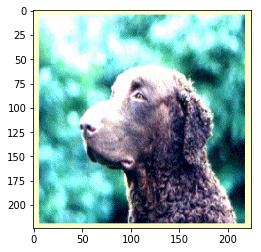

In [5]:
path = classification_path+"/train/"+train_folder[1]
images = os.listdir(path)

# code to display an image
im = Image.open(path+'/'+images[19])
#im.show()

# code to resize the image into 224x224
plt.imshow(skimage.transform.resize((np.asarray(im)), (224, 224)))

a = np.asarray(im)[None]
a

In [6]:
# test script : DELETE
im.close()

Our main interest is with the classification folder under Data. Creating hd5 files of different sizes for train/val/test folders would be a good way to go about it. The main problem is to replicate randomness in the way it is stored. We dont want images of the same class to be saved in a sequence.

Let us create 130 h5 files, each file containing 10,000 images. The distribution has to be kept homogenous.

steps involved:
- check for different image modes and format in the dataset, convert to RGB if different
- resize the images to 224x224
- create separate homogenous lists of image and labelled data
- shuffle the lists to make them random and distributed for the model to be trained on
- create multiple h5 files to load dynamically while training

In [7]:
# check whether all train folders have 1300 images
# print out anomolous folders and the number of images they contain
anomolous_folders = []
for folder in train_folder:
    if (len(os.listdir(classification_path+"/train/"+folder)) == 1300):
        continue
    else:
        print(folder)
        anomolous_folders.append(folder)
print(len(anomolous_folders))
len(os.listdir(classification_path+"/train/"+anomolous_folders[104]))

n02099429
n07716906
n02916936
n03062245
n07730033
n03595614
n03680355
n04040759
n02113978
n04238763
n02093859
n03400231
n02783161
n03947888
n03197337
n03467068
n01873310
n07932039
n04418357
n02093647
n03297495
n04125021
n03041632
n02794156
n03000684
n03075370
n03944341
n03961711
n02526121
n02085782
n02110627
n01744401
n03803284
n03314780
n03133878
n02708093
n04542943
n04127249
n02817516
n01704323
n03706229
n04485082
n04264628
n03781244
n01688243
n02112706
n03995372
n03929660
n03920288
n01855032
n04357314
n04479046
n02102973
n02356798
n02091635
n04525038
n03485407
n03045698
n04201297
n02095889
n04579145
n04266014
n04591157
n02087046
n04328186
n03866082
n03942813
n04548280
n07590611
n04311004
n02978881
n03796401
n04443257
n02606052
n04612504
n03658185
n02088632
n07584110
n03690938
n03764736
n07248320
n04265275
n03899768
n03970156
n04370456
n04429376
n02095314
n02089078
n03956157
n03903868
n03498962
n03476991
n03958227
n04023962
n02090379
n02089973
n02089867
n03777754
n04152593
n03447721


1120

In [9]:
# test script : DELETE
image_files = os.listdir(classification_training_path+train_folder[0])
image = Image.open(classification_training_path+train_folder[0]+'/'+image_files[2])
print(image.mode)
image.close()

RGB


Following cell checks all the images in the dataset for the stored format. The model we train needs to have a fixed dimension of images - 224x224x3. There are a few images in the dataset that are of different dimensions. Lets get to the bottom of that.

In [14]:
# DON'T RUN THIS CELL
# code to check all the different image formats and dimensions.
image_mode_dict = {}
for folder in train_folder:
    temp_path = classification_training_path+folder
    image_files = os.listdir(temp_path)
    for image_file in image_files:
        try:
            image = Image.open(temp_path + '/' + image_file)
            if image.mode in image_mode_dict:
                image_mode_dict[image.mode] += 1
            else:
                image_mode_dict[image.mode] = 1
                
        finally:
            image.close()
print(image_mode_dict)

/home/aditya/Documents/Projects/atgm_vision_module/env/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2555904 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/aditya/Documents/Projects/atgm_vision_module/env/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1835008 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/aditya/Documents/Projects/atgm_vision_module/env/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 19660800 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/aditya/Documents/Projects/atgm_vision_module/env/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 18481152 bytes but only got 0. Skipping

{'L': 19970, 'RGB': 1261196, 'RGBA': 1}


Following cell implements all the steps mentioned earlier.

/home/aditya/Documents/Projects/atgm_vision_module/env/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


1300
1300


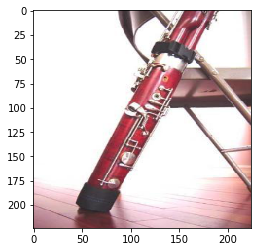

In [48]:
# test script: DELETE
h5file_path = "./ImageNet_dataset/training_folder/train_test_file.hdf5"

image_data = []
label_data = []

test_path = classification_training_path+train_folder[0]
image_files = os.listdir(test_path)
for image_file in image_files:
    # code to check the number of channels of each image loaded and resize appropriately
    image = Image.open(test_path+'/'+image_file)
    if image.mode == 'L':
        rgbimage = Image.new("RGB", image.size)
        rgbimage.paste(image)
        resized_image = skimage.transform.resize((np.asarray(rgbimage)), (224, 224))
        image_data.append(resized_image)
        label_data.append(reference_dictionary[folder])
        rgbimage.close()
    elif image.mode == 'RGB':
        resized_image = skimage.transform.resize((np.asarray(image)), (224, 224))
        image_data.append(resized_image)
        label_data.append(reference_dictionary[folder])
    elif image.mode == 'RGBA':
        image_array = np.asarray(image)
        resized_image = skimage.transform.resize(image_array[:, :, :3], (224, 224))
        image_data.append(resized_image)
        label_data.append(reference_dictionary[folder])
    image.close()
    
# initializing the h5 file
X_dataset_shape = (len(image_data), 224, 224, 3)
Y_dataset_shape = (len(image_data),)
h5file = h5py.File(h5file_path, mode = 'w')
h5file.create_dataset("X_train", X_dataset_shape, np.float32)
h5file.create_dataset("Y_train", Y_dataset_shape, np.uint16)

# shuffling the data
c = list(zip(image_data, label_data))
shuffle(c)
image_data, label_data = zip(*c)

#plt.imshow(image_data[0])
print(len(image_data))
print(len(label_data))

# storing the data in the h5 file
length_image_data = len(image_data)
h5file["X_train"][...] = image_data
h5file["Y_train"][...] = label_data

plt.imshow(h5file['X_train'][0])
h5file.close()

In [ ]:
# test script: DELETE
h5_path = "./ImageNet_dataset/training_folder/train_test_file.hdf5"
h5_file = h5py.File(h5_path, mode = 'r')
total_num_samples = h5_file["X_train"].shape
total_labels = h5_file["Y_train"].shape
print(total_num_samples, total_labels)

image = h5_file['X_train'][0]
plt.imshow(image)
print(image)
h5_file.close()

In [51]:
# code to resize and store the images in a h5 file.
n = 0
count = 0
folders_skipped = 0
sample = 2
while folders_skipped != 1000:
        
    # code to initialize a h5 file
    h5file_path = "./ImageNet_dataset/training_folder/train"+str(count)+".hdf5"

    # code to initialize a global variable to store the image data
    image_data = []
    label_data = []
    
    # variable to keep a track of number of skipped folders
    folders_skipped = 0

    # code to recursively go through each folder and select 10 images to store
    for folder in train_folder:
        temp_path = classification_training_path+folder
        image_files = os.listdir(temp_path)
        if (n >= len(image_files)):
            folders_skipped += 1
            continue
        elif ((len(image_files) - 1) - n < sample):
            concerned_image_files = image_files[n:]
        else:
            concerned_image_files = image_files[n:n+sample]
        for image_file in concerned_image_files:

            # code to check the number of channels of each image loaded and resize appropriately
            image = Image.open(temp_path+'/'+image_file)
            if image.mode == 'L':
                rgbimage = Image.new("RGB", image.size)
                rgbimage.paste(image)
                resized_image = skimage.transform.resize((np.asarray(rgbimage)), (224, 224))
                image_data.append(resized_image)
                label_data.append(reference_dictionary[folder])
                rgbimage.close()
            elif image.mode == 'RGB':
                resized_image = skimage.transform.resize((np.asarray(image)), (224, 224))
                image_data.append(resized_image)
                label_data.append(reference_dictionary[folder])
            elif image.mode == 'RGBA':
                image_array = np.asarray(image)
                resized_image = skimage.transform.resize(image_array[:, :, :3], (224, 224))
                image_data.append(resized_image)
                label_data.append(reference_dictionary[folder])
            image.close()

    # increment n
    n += sample

    # initializing the h5 file
    X_dataset_shape = (len(image_data), 224, 224, 3)
    Y_dataset_shape = (len(image_data),)
    h5file = h5py.File(h5file_path, mode = 'w')
    h5file.create_dataset("X_train", X_dataset_shape, np.float16)
    h5file.create_dataset("Y_train", Y_dataset_shape, np.uint16)

    # shuffling the data
    c = list(zip(image_data, label_data))
    shuffle(c)
    image_data, label_data = zip(*c)
    
    print(len(image_data))
    print(len(label_data))

    # storing the data in the h5 file
    h5file["X_train"][...] = image_data
    h5file["Y_train"][...] = label_data
    h5file.close()
    count += 1

/home/aditya/Documents/Projects/atgm_vision_module/env/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000


/home/aditya/Documents/Projects/atgm_vision_module/env/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1835008 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))


2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000


/home/aditya/Documents/Projects/atgm_vision_module/env/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000


/home/aditya/Documents/Projects/atgm_vision_module/env/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2555904 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))


2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000


/home/aditya/Documents/Projects/atgm_vision_module/env/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 19660800 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/aditya/Documents/Projects/atgm_vision_module/env/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 18481152 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/aditya/Documents/Projects/atgm_vision_module/env/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 37093376 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/aditya/Documents/Projects/atgm_vision_module/env/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 39976960 bytes but only got 0. Skippi

2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
1998
1998
1998
1998
1998
1998
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1996
1993
1993
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1992
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990
1990


ValueError: not enough values to unpack (expected 2, got 0)

In [50]:
print(image.mode)
image_array = np.asarray(image)
image_array.shape
print(n)
h5file.close()

RGB
828


In [28]:
# code to check h5 files
h5_path = "./ImageNet_dataset/training_folder/train"+str(6)+".hdf5"
h5_file = h5py.File(h5_path, mode = 'r')
total_num_samples = h5_file["X_train"].shape
total_labels = h5_file["Y_train"].shape
print(total_num_samples, total_labels)

image = h5_file['X_train'][1999]
print(image)

(2000, 224, 224, 3) (2000,)
[[[1 1 1]
  [1 1 1]
  [1 1 1]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[1 1 1]
  [1 1 1]
  [1 1 1]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[1 1 1]
  [1 1 1]
  [1 1 1]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 1 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 1 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
